# CS-493D Machine Learning Final Project

*This project uses several machine learning models to gain insights from opioid data available from data.gov.*


I looked at the data set titled "Accidental Drug Related Deaths 2012-June 2017" available at: https://catalog.data.gov/dataset/accidental-drug-related-deaths-january-2012-sept-2015.

In particular, I attempted to answer the following question:
"Given an accidental drug overdose related death, can we predict the drug that was used? i.e. whether the overdose is related to a street drug (such as Heroin, Cocaine), or a prescription drug (such as Fentanyl, Oxycodone, Oxymorphone, EtOH, Hydrocodone, Benzodiazepine, Methadone, Amphet, Tramad, Morphine)?"


## Setup 

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [1178]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# For handling data frames
import io
import requests
import pandas as pd

pd.options.mode.chained_assignment = None  # default='warn'

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    if not os.path.exists(IMAGES_PATH):
        os.makedirs(IMAGES_PATH)

    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Get the Data

In [1179]:
DOWNLOAD_URL = "https://data.ct.gov/api/views/rybz-nyjw/rows.csv"
DATA_SET_FILE = "Accidental_Drug_Related_Deaths__2012-June_2017.csv"

def fetch_opioid_data():
    s=requests.get(DOWNLOAD_URL).content
    return pd.read_csv(io.StringIO(s.decode('utf-8')))

In [1180]:
data = fetch_opioid_data()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3583 entries, 0 to 3582
Data columns (total 32 columns):
CaseNumber               3583 non-null object
Date                     3581 non-null object
Sex                      3580 non-null object
Race                     3573 non-null object
Age                      3581 non-null float64
Residence City           3490 non-null object
Residence State          1663 non-null object
Residence County         2885 non-null object
Death City               3579 non-null object
Death State              1702 non-null object
Death County             2405 non-null object
Location                 3561 non-null object
DescriptionofInjury      998 non-null object
InjuryPlace              3506 non-null object
ImmediateCauseA          3581 non-null object
Heroin                   1936 non-null object
Cocaine                  998 non-null object
Fentanyl                 1114 non-null object
Oxycodone                491 non-null object
Oxymorphone          

## Clean the Data

In [1181]:
# Remove all the rows where the age and the MannerofDeath are missing
data = data.dropna(subset=["Age", "MannerofDeath"])

In [1182]:
data.describe()

,Age
count,3574.000000
mean,41.982373
std,12.325512
min,14.000000
25%,32.000000
50%,43.000000
75%,52.000000
max,87.000000


In [1183]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3574 entries, 0 to 3582
Data columns (total 32 columns):
CaseNumber               3574 non-null object
Date                     3574 non-null object
Sex                      3573 non-null object
Race                     3566 non-null object
Age                      3574 non-null float64
Residence City           3484 non-null object
Residence State          1663 non-null object
Residence County         2881 non-null object
Death City               3573 non-null object
Death State              1702 non-null object
Death County             2399 non-null object
Location                 3555 non-null object
DescriptionofInjury      998 non-null object
InjuryPlace              3498 non-null object
ImmediateCauseA          3572 non-null object
Heroin                   1935 non-null object
Cocaine                  994 non-null object
Fentanyl                 1113 non-null object
Oxycodone                490 non-null object
Oxymorphone          

In [1184]:
"""
The DeathLoc includes the city, state as well as the lattitude (lat) and longitude (lon) values. 
By extracting the lat and lon values, we can display the data on a map along with other features.

I have used a regular expression to extract the lat and lon values.
"""
import re

data['DeathLoc2'] = data['DeathLoc'].apply( lambda x: re.sub("\s*[A-Za-z()\s]+\s*", "", str(x)) );

data['lat'] = data['DeathLoc2'].apply( lambda x: x.split(',')[1] )
data['lon'] = data['DeathLoc2'].apply( lambda x: x.split(',')[-1] )

In [1185]:
data['lat'].describe()

count          3574
unique          197
top       41.765775
freq            367
Name: lat, dtype: object

In [1186]:
data['lon'].describe()

count           3574
unique           196
top       -72.673356
freq             367
Name: lon, dtype: object

In [1187]:
#Convert the lat and lon columns from object to numerical values

data['lat'] = pd.to_numeric(data['lat'], errors='coerce').fillna(0)

data['lon'] = pd.to_numeric(data['lon'], errors='coerce').fillna(0)

In [1188]:
data['lat'].describe()

count    3574.000000
mean       41.498188
std         1.924222
min       -72.651713
25%        41.316843
50%        41.554261
75%        41.765775
max        42.025992
Name: lat, dtype: float64

In [1189]:
data['lon'].describe()

count    3574.000000
mean      -72.803145
std         0.391349
min       -73.628549
25%       -73.057564
50%       -72.824947
75%       -72.643785
max       -71.808899
Name: lon, dtype: float64

In [1190]:
# To fix the error due to incorrect data split, we remove the minimum lat values.

data = data[data['lat'] != data['lat'].min()]

# Now we check the lat info to see if the min value is as expected

data['lat'].describe()

count    3573.000000
mean       41.530136
std         0.234034
min        41.026526
25%        41.316843
50%        41.554261
75%        41.765775
max        42.025992
Name: lat, dtype: float64

## Handle the Text and Categorical Features

Many of the columns in the dataset have textual values, therefore, we need to convert to categorical values.

We can use Pandas' `factorize()` method to convert this string categorical feature to an integer categorical feature, which will be easier for Machine Learning algorithms to handle:

Now let's preprocess the categorical input feature, `Sex`:

In [1200]:
train_set['Sex'].head(10)

1044      Male
141       Male
1882      Male
668       Male
1258      Male
2369      Male
657     Female
472       Male
2998      Male
1988    Female
Name: Sex, dtype: object

In [1201]:
sex_categories_encoded, sex_categories = train_set['Sex'].factorize()
train_set['Sex_Encoded'] = sex_categories_encoded
train_set['Sex_Encoded'].head(10)

1044    0
141     0
1882    0
668     0
1258    0
2369    0
657     1
472     0
2998    0
1988    1
Name: Sex_Encoded, dtype: int64

In [1202]:
sex_categories

Index(['Male', 'Female'], dtype='object')

Let's preprocess the categorical input feature, `Race`:

In [1203]:
train_set['Race'].head(10)

1044           White
141            White
1882           White
668            White
1258    Asian Indian
2369           White
657            White
472            Black
2998           White
1988           Black
Name: Race, dtype: object

In [1204]:
race_categories_encoded, race_categories = train_set['Race'].factorize()
train_set['Race_Encoded'] = race_categories_encoded
train_set['Race_Encoded'].head(10)

1044    0
141     0
1882    0
668     0
1258    1
2369    0
657     0
472     2
2998    0
1988    2
Name: Race_Encoded, dtype: int64

In [1205]:
race_categories

Index(['White', 'Asian Indian', 'Black', 'Hispanic, White', 'Unknown', 'Other',
       'Asian, Other', 'Hispanic, Black', 'Chinese', 'Native American, Other',
       'Hawaiian'],
      dtype='object')

Let's preprocess the categorical input feature, `MannerofDeath`:

In [1206]:
train_set['MannerofDeath'].head(10)

1044    Accident
141     Accident
1882    Accident
668     Accident
1258    Accident
2369    Accident
657     Accident
472      Pending
2998    Accident
1988    Accident
Name: MannerofDeath, dtype: object

In [1207]:
MannerofDeath_categories_encoded, MannerofDeath_categories = train_set['MannerofDeath'].factorize()

In [1208]:
MannerofDeath_categories

Index(['Accident', 'Pending', 'accident', 'Natural', 'ACCIDENT'], dtype='object')

In [1209]:
# This is a manual step to clean up, and consolidate the categories
# since there are some redundant categories for Accident.
manner_of_death_classification_dict = {
    'Accident': ['Accident','accident','ACCIDENT'], 
    'Pending': ['Pending'], 
    'Natural': ['Natural']}
manner_of_death_classification = {v: k for k,vv in manner_of_death_classification_dict.items() for v in vv}
manner_of_death_classification

{'ACCIDENT': 'Accident',
 'Accident': 'Accident',
 'Natural': 'Natural',
 'Pending': 'Pending',
 'accident': 'Accident'}

In [1210]:
train_set['MannerofDeath'] = train_set['MannerofDeath'].apply( lambda x: manner_of_death_classification[x], str(x))

In [1211]:
# Now that the MannerofDeath categories are cleaned up, let's run the factorize again, 
# and update the manner_of_death categories

manner_of_death_final_categories_encoded, manner_of_death_final_categories = train_set['MannerofDeath'].factorize()
train_set['MannerofDeath_Encoded'] = manner_of_death_final_categories_encoded
train_set['MannerofDeath_Encoded'].head(10)

1044    0
141     0
1882    0
668     0
1258    0
2369    0
657     0
472     1
2998    0
1988    0
Name: MannerofDeath_Encoded, dtype: int64

In [1212]:
manner_of_death_final_categories

Index(['Accident', 'Pending', 'Natural'], dtype='object')

Let's preprocess the categorical input feature, `Location`:

In [1213]:
train_set['Location'].head(10)

1044        Other
141     Residence
1882    Residence
668      Hospital
1258    Residence
2369        Other
657     Residence
472     Residence
2998    Residence
1988     Hospital
Name: Location, dtype: object

In [1214]:
death_location_categories_encoded, death_location_categories = train_set['Location'].factorize()
train_set['Location_Encoded'] = death_location_categories_encoded
train_set['Location_Encoded'].head(10)

1044    0
141     1
1882    1
668     2
1258    1
2369    0
657     1
472     1
2998    1
1988    2
Name: Location_Encoded, dtype: int64

In [1215]:
death_location_categories

Index(['Other', 'Residence', 'Hospital', 'Hospice', 'Convalescent Home'], dtype='object')

Let's preprocess the categorical input feature, `InjuryPlace`:

In [1216]:
train_set['InjuryPlace'].head(10)

1044          Hotel or Motel
141                Residence
1882               Residence
668                Residence
1258               Residence
2369    Residential Building
657                Residence
472                      NaN
2998               Residence
1988                 Unknown
Name: InjuryPlace, dtype: object

In [1217]:
injury_place_categories_encoded, injury_place_categories = train_set['InjuryPlace'].factorize()
train_set['InjuryPlace_Encoded'] = injury_place_categories_encoded
train_set['InjuryPlace_Encoded'].head(10)

1044    0
141     1
1882    1
668     1
1258    1
2369    2
657     1
472    -1
2998    1
1988    3
Name: InjuryPlace_Encoded, dtype: int64

In [1218]:
injury_location_categories

Index(['Residence', 'Residential Building', 'Other', 'Restaurant',
       'Automobile', 'Hospital', 'Unknown', 'Hotel or Motel',
       'Other indoor Area', 'Other, Industrial Area', 'Other (unknown)',
       'Other, Other Outdoor Area', 'Other, Public Buildings', 'In Vehicle',
       'Store or Shopping Area', 'Other, Residential Institution', 'Alleyway',
       'Office Building', 'Driveway', 'Hospital or Emergency Room',
       'Apartment', 'Parking Lot', 'Public Park, Urban or Suburban', 'Casino',
       'School, Primary or Secondary', 'Bar or Night Club', 'Campgrounds',
       'Boat/Marina', 'Forest, Wooded Area', 'Sidewalk', 'Porch', 'Field',
       'House', 'Street', 'Roadway', 'Halfway House',
       'Train or Subway Station', 'Public Park', 'Beach',
       'Other, Park or Recreational Area', 'Nursing Home',
       'Detoxification Center', 'Rest Home', 'Rehab House', 'Garage',
       'Building', 'Friend's Residence', 'homeless shelter', 'Backyard',
       'University or College',

Let's preprocess the different drug types available in the data, and create 
categorical input feature called `DrugType`, which specifies whether it is a `street_drug` 
or a `prescription_drug`.

In [1219]:
# Combine the drugs found in the decesed individual into either street or prescription drugs.

drug_types = { 
'street_drug': 
    ['Heroin', 'Cocaine'],
'prescription_drug' : 
    ['Fentanyl', 'Oxycodone', 'Oxymorphone','EtOH','Hydrocodone', 'Benzodiazepine', 'Methadone', 'Amphet', 'Tramad', 'Morphine (not heroin)', 'Other', 'Any Opioid']}

drug_types

{'prescription_drug': ['Fentanyl',
  'Oxycodone',
  'Oxymorphone',
  'EtOH',
  'Hydrocodone',
  'Benzodiazepine',
  'Methadone',
  'Amphet',
  'Tramad',
  'Morphine (not heroin)',
  'Other',
  'Any Opioid'],
 'street_drug': ['Heroin', 'Cocaine']}

In [1220]:
drug_type_list = {v: k for k,vv in drug_types.items() for v in vv}

In [1221]:
def label_drug (row):
    for k, v in drug_type_list.items():
        if row[k]  == 'Y' or row[k] == 'y':
            return v

train_set['DrugType'] = train_set.apply (lambda row: label_drug (row),axis=1)

train_set['DrugType'].value_counts()

prescription_drug    2167
street_drug           644
Name: DrugType, dtype: int64

In [1222]:
train_set['DrugType'].head(10)

1044    prescription_drug
141     prescription_drug
1882    prescription_drug
668     prescription_drug
1258          street_drug
2369          street_drug
657     prescription_drug
472                  None
2998    prescription_drug
1988          street_drug
Name: DrugType, dtype: object

Let's apply the same preprocess the categorical input feature, `DrugType`:

In [1223]:
drug_type_categories_encoded, drug_type_categories = train_set['DrugType'].factorize()
train_set['DrugType_Encoded'] = drug_type_categories_encoded
train_set['DrugType_Encoded'].head(10)

1044    0
141     0
1882    0
668     0
1258    1
2369    1
657     0
472    -1
2998    0
1988    1
Name: DrugType_Encoded, dtype: int64

In [1224]:
drug_type_categories

Index(['prescription_drug', 'street_drug'], dtype='object')

## Split Data Into Train and Test Sets

In [1191]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)

In [1192]:
test_set.head()

,CaseNumber,Date,Sex,Race,Age,Residence City,Residence State,Residence County,Death City,Death State,...,Tramad,Morphine (not heroin),Other,Any Opioid,MannerofDeath,AmendedMannerofDeath,DeathLoc,DeathLoc2,lat,lon
458,14-8859,06/06/2014,Male,White,54.0,NaN,NaN,NaN,DANBURY,NaN,...,NaN,NaN,NaN,NaN,Accident,NaN,"DANBURY, CT\n(41.393666, -73.451539)",",41.393666,-73.451539",41.393666,-73.451539
1655,15-193,01/05/2015,Male,Unknown,51.0,HARTFORD,CT,HARTFORD,HARTFORD,CT,...,NaN,NaN,NaN,Y,Accident,NaN,"HARTFORD, CT\n(41.765775, -72.673356)",",41.765775,-72.673356",41.765775,-72.673356
351,15-170,01/04/2015,Male,White,28.0,MILFORD,CT,NEW HAVEN,MILFORD,CT,...,NaN,NaN,NaN,Y,Accident,NaN,"MILFORD, CT\n(41.224276, -73.057564)",",41.224276,-73.057564",41.224276,-73.057564
1675,14-15562,10/17/2014,Male,White,35.0,WATERBURY,NaN,NaN,WATERBURY,NaN,...,NaN,NaN,NaN,NaN,Accident,NaN,"WATERBURY, CT\n(41.554261, -73.043069)",",41.554261,-73.043069",41.554261,-73.043069
1858,13-8559,06/05/2013,Female,"Hispanic, White",46.0,BRIDGEPORT,NaN,FAIRFIELD,BRIDGEPORT,NaN,...,NaN,NaN,NaN,NaN,Accident,NaN,"BRIDGEPORT, CT\n(41.179195, -73.189476)",",41.179195,-73.189476",41.179195,-73.189476


In [1193]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 715 entries, 458 to 1601
Data columns (total 35 columns):
CaseNumber               715 non-null object
Date                     715 non-null object
Sex                      715 non-null object
Race                     714 non-null object
Age                      715 non-null float64
Residence City           688 non-null object
Residence State          308 non-null object
Residence County         573 non-null object
Death City               715 non-null object
Death State              319 non-null object
Death County             474 non-null object
Location                 709 non-null object
DescriptionofInjury      203 non-null object
InjuryPlace              704 non-null object
ImmediateCauseA          715 non-null object
Heroin                   384 non-null object
Cocaine                  204 non-null object
Fentanyl                 209 non-null object
Oxycodone                106 non-null object
Oxymorphone              26 non-null

In [1194]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2858 entries, 1044 to 3184
Data columns (total 35 columns):
CaseNumber               2858 non-null object
Date                     2858 non-null object
Sex                      2857 non-null object
Race                     2851 non-null object
Age                      2858 non-null float64
Residence City           2795 non-null object
Residence State          1355 non-null object
Residence County         2307 non-null object
Death City               2858 non-null object
Death State              1383 non-null object
Death County             1925 non-null object
Location                 2845 non-null object
DescriptionofInjury      795 non-null object
InjuryPlace              2793 non-null object
ImmediateCauseA          2856 non-null object
Heroin                   1551 non-null object
Cocaine                  789 non-null object
Fentanyl                 904 non-null object
Oxycodone                384 non-null object
Oxymorphone        

In [1195]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3573 entries, 0 to 3582
Data columns (total 35 columns):
CaseNumber               3573 non-null object
Date                     3573 non-null object
Sex                      3572 non-null object
Race                     3565 non-null object
Age                      3573 non-null float64
Residence City           3483 non-null object
Residence State          1663 non-null object
Residence County         2880 non-null object
Death City               3573 non-null object
Death State              1702 non-null object
Death County             2399 non-null object
Location                 3554 non-null object
DescriptionofInjury      998 non-null object
InjuryPlace              3497 non-null object
ImmediateCauseA          3571 non-null object
Heroin                   1935 non-null object
Cocaine                  993 non-null object
Fentanyl                 1113 non-null object
Oxycodone                490 non-null object
Oxymorphone          

## Visualize the Data

Saving figure histogram_plots


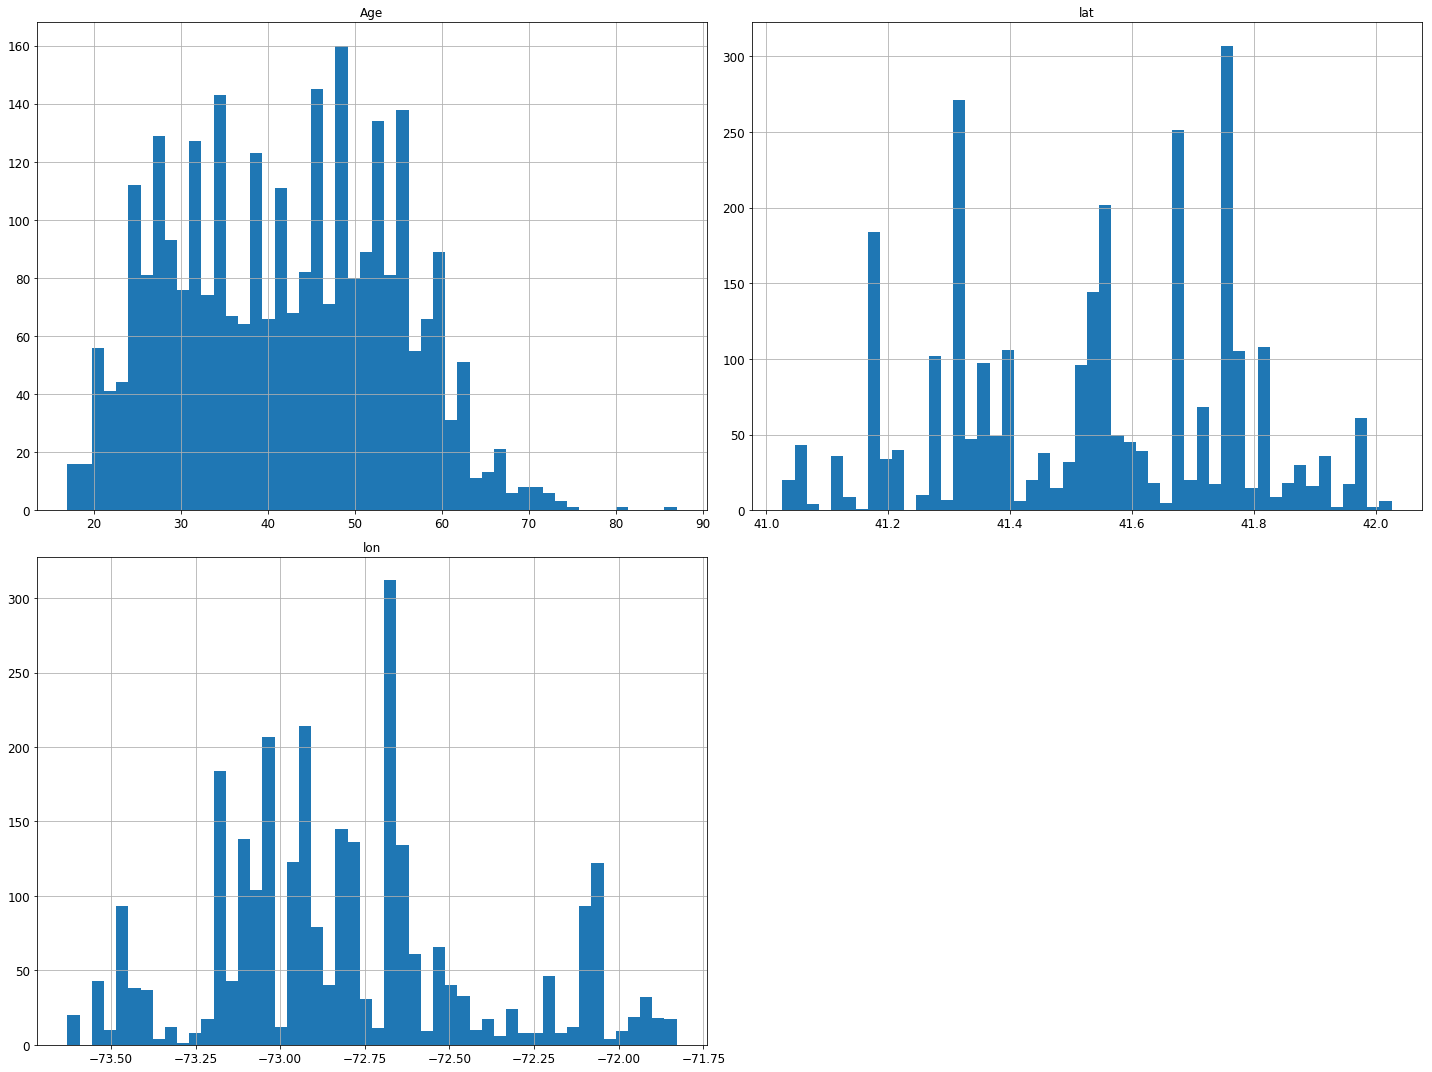

In [1196]:
# Generate the histogram plots of the different numerical data

%matplotlib inline
import matplotlib.pyplot as plt
train_set.hist(bins=50, figsize=(20,15))
save_fig("histogram_plots")
plt.show()

Saving figure lat_lon_raw_visualization_plot


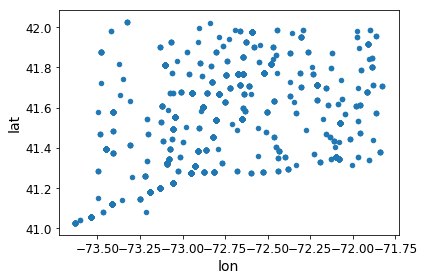

In [1197]:
# Scatter plot of the Age of the individuals who died plotted against the lat and lon values
# Notice the outline of Connecticut in this plot.

train_set.plot(kind="scatter", x="lon", y="lat")
save_fig("lat_lon_raw_visualization_plot")

Saving figure lat_lon_visualization_plot


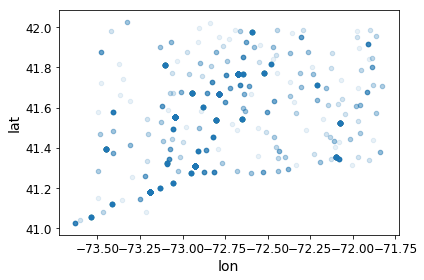

In [1198]:
# Better visualization highlighting the high density areas

train_set.plot(kind="scatter", x="lon", y="lat", alpha=0.1)
save_fig("lat_lon_visualization_plot")

Saving figure age_opioid_scatterplot


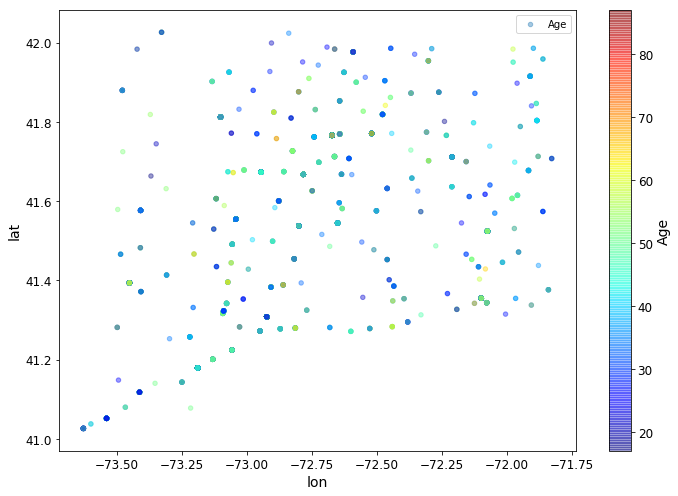

In [1199]:
# Even better plot with a color map showing the age of the individuals who died.

train_set.plot(kind="scatter", x="lon", y="lat", alpha=0.4,
    label="Age", figsize=(10,7),
    c="Age", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()
save_fig("age_opioid_scatterplot")

## Seperate the Data Frame Into Numerical and Categorical Frames

In [1225]:
train_set_num = train_set.filter(['Age','lat','lon'], axis=1)
train_set_num.head()

,Age,lat,lon
1044,62.0,41.576633,-73.408713
141,25.0,41.382918,-72.907743
1882,54.0,41.667528,-72.783437
668,30.0,41.554261,-73.043069
1258,58.0,41.279802,-72.814040


In [1226]:
train_set_cat = train_set.filter(['Sex','Race','MannerofDeath','Location', 'InjuryPlace', 'DrugType'], axis=1)
train_set_cat.head()

,Sex,Race,MannerofDeath,Location,InjuryPlace,DrugType
1044,Male,White,Accident,Other,Hotel or Motel,prescription_drug
141,Male,White,Accident,Residence,Residence,prescription_drug
1882,Male,White,Accident,Residence,Residence,prescription_drug
668,Male,White,Accident,Hospital,Residence,prescription_drug
1258,Male,Asian Indian,Accident,Residence,Residence,street_drug


In [1227]:
train_set_cat_encoded = train_set.filter(['Sex_Encoded','Race_Encoded','MannerofDeath_Encoded','Location_Encoded', 'InjuryPlace_Encoded', 'DrugType_Encoded'], axis=1)
train_set_cat_encoded.head()

,Sex_Encoded,Race_Encoded,MannerofDeath_Encoded,Location_Encoded,InjuryPlace_Encoded,DrugType_Encoded
1044,0,0,0,0,0,0
141,0,0,0,1,1,0
1882,0,0,0,1,1,0
668,0,0,0,2,1,0
1258,0,1,0,1,1,1


## Encode the Categories

In [1228]:
# Definition of the CategoricalEncoder class, copied from PR #9151.
# https://github.com/scikit-learn/scikit-learn/pull/9151

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """Encode categorical features as a numeric array.
    The input to this transformer should be a matrix of integers or strings,
    denoting the values taken on by categorical (discrete) features.
    The features can be encoded using a one-hot aka one-of-K scheme
    (``encoding='onehot'``, the default) or converted to ordinal integers
    (``encoding='ordinal'``).
    This encoding is needed for feeding categorical data to many scikit-learn
    estimators, notably linear models and SVMs with the standard kernels.
    Read more in the :ref:`User Guide <preprocessing_categorical_features>`.
    Parameters
    ----------
    encoding : str, 'onehot', 'onehot-dense' or 'ordinal'
        The type of encoding to use (default is 'onehot'):
        - 'onehot': encode the features using a one-hot aka one-of-K scheme
          (or also called 'dummy' encoding). This creates a binary column for
          each category and returns a sparse matrix.
        - 'onehot-dense': the same as 'onehot' but returns a dense array
          instead of a sparse matrix.
        - 'ordinal': encode the features as ordinal integers. This results in
          a single column of integers (0 to n_categories - 1) per feature.
    categories : 'auto' or a list of lists/arrays of values.
        Categories (unique values) per feature:
        - 'auto' : Determine categories automatically from the training data.
        - list : ``categories[i]`` holds the categories expected in the ith
          column. The passed categories are sorted before encoding the data
          (used categories can be found in the ``categories_`` attribute).
    dtype : number type, default np.float64
        Desired dtype of output.
    handle_unknown : 'error' (default) or 'ignore'
        Whether to raise an error or ignore if a unknown categorical feature is
        present during transform (default is to raise). When this is parameter
        is set to 'ignore' and an unknown category is encountered during
        transform, the resulting one-hot encoded columns for this feature
        will be all zeros.
        Ignoring unknown categories is not supported for
        ``encoding='ordinal'``.
    Attributes
    ----------
    categories_ : list of arrays
        The categories of each feature determined during fitting. When
        categories were specified manually, this holds the sorted categories
        (in order corresponding with output of `transform`).
    Examples
    --------
    Given a dataset with three features and two samples, we let the encoder
    find the maximum value per feature and transform the data to a binary
    one-hot encoding.
    >>> from sklearn.preprocessing import CategoricalEncoder
    >>> enc = CategoricalEncoder(handle_unknown='ignore')
    >>> enc.fit([[0, 0, 3], [1, 1, 0], [0, 2, 1], [1, 0, 2]])
    ... # doctest: +ELLIPSIS
    CategoricalEncoder(categories='auto', dtype=<... 'numpy.float64'>,
              encoding='onehot', handle_unknown='ignore')
    >>> enc.transform([[0, 1, 1], [1, 0, 4]]).toarray()
    array([[ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
           [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])
    See also
    --------
    sklearn.preprocessing.OneHotEncoder : performs a one-hot encoding of
      integer ordinal features. The ``OneHotEncoder assumes`` that input
      features take on values in the range ``[0, max(feature)]`` instead of
      using the unique values.
    sklearn.feature_extraction.DictVectorizer : performs a one-hot encoding of
      dictionary items (also handles string-valued features).
    sklearn.feature_extraction.FeatureHasher : performs an approximate one-hot
      encoding of dictionary items or strings.
    """

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

The `CategoricalEncoder` expects a 2D array containing one or more categorical input features. We need to reshape `sex_categories` to a 2D array:

In [1229]:
cat_encoder = CategoricalEncoder()
sex_categories_reshaped = sex_categories.values.reshape(-1, 1)
sex_categories_1hot = cat_encoder.fit_transform(sex_categories_reshaped)
sex_categories_1hot

<2x2 sparse matrix of type '<class 'numpy.float64'>'
	with 2 stored elements in Compressed Sparse Row format>

The default encoding is one-hot, and it returns a sparse array. You can use `toarray()` to get a dense array:

In [1230]:
sex_categories_1hot.toarray()

array([[ 0.,  1.],
       [ 1.,  0.]])

Alternatively, we can specify the encoding to be `"onehot-dense"` to get a dense matrix rather than a sparse matrix:

In [1231]:
cat_encoder.categories_

[array(['Female', 'Male'], dtype=object)]

In [1232]:
cat_encoder = CategoricalEncoder(encoding="onehot-dense")
sex_categories_1hot = cat_encoder.fit_transform(sex_categories_reshaped)
sex_categories_1hot

array([[ 0.,  1.],
       [ 1.,  0.]])

## Gather Insights

In [1233]:
corr_matrix = train_set.corr()
corr_matrix

,Age,lat,lon,Sex_Encoded,Race_Encoded,MannerofDeath_Encoded,Location_Encoded,InjuryPlace_Encoded,DrugType_Encoded
Age,1.000000,-0.008554,-0.000961,0.050691,0.045306,0.009995,0.004673,-0.044186,-0.025137
lat,-0.008554,1.000000,0.417001,-0.002820,-0.032332,-0.020233,-0.048717,-0.026168,-0.004510
lon,-0.000961,0.417001,1.000000,-0.021295,-0.036093,-0.028545,-0.039946,-0.027431,-0.034037
Sex_Encoded,0.050691,-0.002820,-0.021295,1.000000,-0.063858,0.005677,0.052416,-0.026658,-0.022682
Race_Encoded,0.045306,-0.032332,-0.036093,-0.063858,1.000000,0.011077,0.042735,0.047317,0.063099
MannerofDeath_Encoded,0.009995,-0.020233,-0.028545,0.005677,0.011077,1.000000,0.032607,-0.019255,-0.007779
Location_Encoded,0.004673,-0.048717,-0.039946,0.052416,0.042735,0.032607,1.000000,-0.016755,0.052606
InjuryPlace_Encoded,-0.044186,-0.026168,-0.027431,-0.026658,0.047317,-0.019255,-0.016755,1.000000,0.027282
DrugType_Encoded,-0.025137,-0.004510,-0.034037,-0.022682,0.063099,-0.007779,0.052606,0.027282,1.000000


In [1234]:
# Corelation between the drug type and other parameters

corr_matrix["DrugType_Encoded"].sort_values(ascending=False)

DrugType_Encoded         1.000000
Race_Encoded             0.063099
Location_Encoded         0.052606
InjuryPlace_Encoded      0.027282
lat                     -0.004510
MannerofDeath_Encoded   -0.007779
Sex_Encoded             -0.022682
Age                     -0.025137
lon                     -0.034037
Name: DrugType_Encoded, dtype: float64

## Build the Machine Learning Pipeline

Now let's build a pipeline for preprocessing the numerical attributes:

In [1235]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer

num_pipeline = Pipeline([
        ('imputer', Imputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

train_set_num_tr = num_pipeline.fit_transform(train_set_num)

In [1236]:
train_set_num_tr

array([[ 1.62715007,  0.2022045 , -1.53933429],
       [-1.36538204, -0.62637794, -0.26693065],
       [ 0.9801161 ,  0.59099216,  0.04879166],
       ..., 
       [-0.15219335, -1.49776788, -0.98249864],
       [ 0.81835761, -0.74507805,  1.78575456],
       [-1.60801978, -1.75930505, -1.549984  ]])

And a transformer to just select a subset of the Pandas DataFrame columns:

In [1237]:
from sklearn.base import BaseEstimator, TransformerMixin

# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

Now let's join all these components into a big pipeline that will preprocess both the numerical and the categorical features:

In [1238]:
num_attribs = list(train_set_num)
cat_attribs = list(train_set_cat_encoded)

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('cat_encoder', CategoricalEncoder(encoding="onehot-dense")),
    ])

In [1239]:
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [1240]:
train_set_prepared = full_pipeline.fit_transform(train_set)
train_set_prepared

array([[ 1.62715007,  0.2022045 , -1.53933429, ...,  0.        ,
         1.        ,  0.        ],
       [-1.36538204, -0.62637794, -0.26693065, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.9801161 ,  0.59099216,  0.04879166, ...,  0.        ,
         1.        ,  0.        ],
       ..., 
       [-0.15219335, -1.49776788, -0.98249864, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.81835761, -0.74507805,  1.78575456, ...,  0.        ,
         1.        ,  0.        ],
       [-1.60801978, -1.75930505, -1.549984  , ...,  0.        ,
         1.        ,  0.        ]])

In [1241]:
train_set_prepared.shape

(2858, 92)

## Select and Train a Model 

### Model for Predicting `DrugType` 

### Model for Predicting `Age` 

In [1242]:
from sklearn.linear_model import LinearRegression

opioid_labels = train_set["Age"].copy()

lin_reg = LinearRegression()
lin_reg.fit(train_set_prepared, opioid_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [1243]:
# let's try the full pipeline on a few training instances
some_data = train_set.iloc[:5]
some_labels = opioid_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [ 62.  25.  54.  30.  58.]


Compare against the actual values:

In [1244]:
print("Labels:", list(some_labels))

Labels: [62.0, 25.0, 54.0, 30.0, 58.0]


In [1245]:
from sklearn.metrics import mean_squared_error

opioid_predictions = lin_reg.predict(train_set_prepared)
lin_mse = mean_squared_error(opioid_labels, opioid_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

2.4554371725665121e-14

In [1246]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(opioid_labels, opioid_predictions)
lin_mae

2.0539359032477494e-14

In [1247]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(train_set_prepared, opioid_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [1248]:
opioid_predictions = tree_reg.predict(train_set_prepared)
tree_mse = mean_squared_error(opioid_labels, opioid_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

## Fine-tuning the Model

In [1249]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, train_set_prepared, opioid_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [1250]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [ 0.56096819  0.          0.          0.          0.          0.11826248
  0.70957488  0.11826248  0.          0.        ]
Mean: 0.150706802759
Standard deviation: 0.248802821965


In [1251]:
lin_scores = cross_val_score(lin_reg, train_set_prepared, opioid_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [  2.24883929e-03   3.82223205e-05   1.48783906e-14   2.51880689e-03
   6.85907685e-04   6.90729609e-04   2.28384990e-14   6.52910918e-04
   1.62985537e-03   4.07370285e-02]
Mean: 0.00492023005821
Standard deviation: 0.0119701807741


In [1252]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(train_set_prepared, opioid_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [1253]:
opioid_predictions = forest_reg.predict(train_set_prepared)
forest_mse = mean_squared_error(opioid_labels, opioid_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

0.12774624952897595

In [1254]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, train_set_prepared, opioid_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [ 0.29601077  0.00591312  0.00591312  0.01024183  0.01182625  0.1362587
  0.76920629  0.01961161  0.02135744  0.02442317]
Mean: 0.130076231992
Standard deviation: 0.230308663288


In [1255]:
scores = cross_val_score(lin_reg, train_set_prepared, opioid_labels, scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()

count    1.000000e+01
mean     4.920230e-03
std      1.261768e-02
min      3.879309e-15
25%      1.918945e-04
50%      6.883186e-04
75%      2.094093e-03
max      4.073703e-02
dtype: float64

In [1256]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(train_set_prepared, opioid_labels)
opioid_predictions = svm_reg.predict(train_set_prepared)
svm_mse = mean_squared_error(opioid_labels, opioid_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

0.044602693803930143

In [1257]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error')
grid_search.fit(train_set_prepared, opioid_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'max_features': [2, 4, 6, 8], 'n_estimators': [3, 10, 30]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

The best hyperparameter combination found:

In [1258]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [1259]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

Let's look at the score of each hyperparameter combination tested during the grid search:

In [1260]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

5.85041901171 {'max_features': 2, 'n_estimators': 3}
4.85237951411 {'max_features': 2, 'n_estimators': 10}
4.55305067219 {'max_features': 2, 'n_estimators': 30}
6.17740162217 {'max_features': 4, 'n_estimators': 3}
4.39485725966 {'max_features': 4, 'n_estimators': 10}
4.17434635813 {'max_features': 4, 'n_estimators': 30}
5.61058778385 {'max_features': 6, 'n_estimators': 3}
3.96266238114 {'max_features': 6, 'n_estimators': 10}
3.59566723823 {'max_features': 6, 'n_estimators': 30}
5.08045831427 {'max_features': 8, 'n_estimators': 3}
3.64947246466 {'max_features': 8, 'n_estimators': 10}
3.45191722337 {'max_features': 8, 'n_estimators': 30}
4.69925051049 {'bootstrap': False, 'n_estimators': 3, 'max_features': 2}
4.5842823021 {'bootstrap': False, 'n_estimators': 10, 'max_features': 2}
5.44508324706 {'bootstrap': False, 'n_estimators': 3, 'max_features': 3}
4.42571866447 {'bootstrap': False, 'n_estimators': 10, 'max_features': 3}
4.91558869388 {'bootstrap': False, 'n_estimators': 3, 'max_feat

In [1261]:
pd.DataFrame(grid_search.cv_results_)

/Users/oshani/anaconda/envs/opioid-data-ml/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/oshani/anaconda/envs/opioid-data-ml/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/oshani/anaconda/envs/opioid-data-ml/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_bootstrap,param_max_features,param_n_estimators,params,rank_test_score,split0_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.014322,0.001303,-34.227403,-9.865596,NaN,2,3,"{'max_features': 2, 'n_estimators': 3}",17,-24.610528,...,-44.377040,-11.916010,-28.221444,-7.639120,-27.792177,-10.017684,0.001076,0.000095,9.104179,2.121668
1,0.040945,0.002460,-23.545587,-4.893773,NaN,2,10,"{'max_features': 2, 'n_estimators': 10}",12,-22.364493,...,-23.108706,-5.202227,-22.427443,-4.559130,-18.712207,-4.608745,0.001171,0.000157,4.082960,0.496780
2,0.119013,0.005922,-20.730270,-3.309823,NaN,2,30,"{'max_features': 2, 'n_estimators': 30}",9,-22.836876,...,-19.280484,-3.393413,-21.651455,-3.188764,-16.585010,-3.375617,0.003725,0.000235,2.494938,0.099363
3,0.014229,0.001256,-38.160291,-9.856388,NaN,4,3,"{'max_features': 4, 'n_estimators': 3}",18,-39.248252,...,-38.019037,-8.945708,-38.170656,-9.291308,-28.417202,-9.299276,0.000960,0.000094,5.881869,1.232750
4,0.043982,0.002906,-19.314770,-3.859121,NaN,4,10,"{'max_features': 4, 'n_estimators': 10}",6,-19.825105,...,-15.914283,-3.537533,-23.333888,-4.382379,-13.572421,-3.481112,0.002603,0.000464,4.054103,0.395441
5,0.128844,0.006063,-17.425168,-2.844695,NaN,4,30,"{'max_features': 4, 'n_estimators': 30}",5,-19.477830,...,-15.050156,-2.664961,-19.370567,-3.048386,-13.272877,-2.829535,0.005242,0.000316,2.729360,0.124441
6,0.013579,0.001065,-31.478695,-8.224122,NaN,6,3,"{'max_features': 6, 'n_estimators': 3}",16,-38.744172,...,-18.666861,-5.066638,-28.560226,-7.769664,-32.106246,-10.511636,0.001058,0.000136,7.581386,1.821304
7,0.041104,0.002403,-15.702693,-3.212530,NaN,6,10,"{'max_features': 6, 'n_estimators': 10}",4,-16.519218,...,-11.250792,-2.598429,-19.705340,-3.535112,-12.946835,-3.428456,0.003164,0.000383,3.156308,0.345509
8,0.130549,0.006179,-12.928823,-2.135009,NaN,6,30,"{'max_features': 6, 'n_estimators': 30}",2,-15.499332,...,-11.555046,-2.140167,-13.557408,-1.955248,-9.481813,-2.056407,0.004131,0.000605,2.162434,0.120121
9,0.014434,0.001305,-25.811057,-7.560427,NaN,8,3,"{'max_features': 8, 'n_estimators': 3}",14,-25.835859,...,-36.123349,-11.201128,-29.489784,-7.244571,-17.381981,-6.959870,0.001377,0.000182,6.666910,1.891648


In [1262]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(train_set_prepared, opioid_labels)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a2b3428d0>, 'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a2b342f60>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=0)

In [1263]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

3.30002935598 {'max_features': 7, 'n_estimators': 180}
4.17163862265 {'max_features': 5, 'n_estimators': 15}
4.16426051232 {'max_features': 3, 'n_estimators': 72}
3.86688737401 {'max_features': 5, 'n_estimators': 21}
3.32922412684 {'max_features': 7, 'n_estimators': 122}
4.15755742834 {'max_features': 3, 'n_estimators': 75}
4.21701031089 {'max_features': 3, 'n_estimators': 88}
3.75968774954 {'max_features': 5, 'n_estimators': 100}
4.19848170308 {'max_features': 3, 'n_estimators': 150}
6.39051628513 {'max_features': 5, 'n_estimators': 2}


In [1264]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([  7.95335533e-01,   4.66203263e-02,   4.96193343e-02,
         1.00698100e-05,   5.96266807e-03,   5.17233383e-03,
         1.30572869e-03,   5.71439863e-03,   2.60618740e-04,
         9.18107422e-03,   3.28905645e-03,   1.69811851e-03,
         3.15043733e-04,   1.25319302e-03,   8.87412303e-04,
         3.71659763e-04,   3.76884199e-05,   8.96694641e-05,
         6.65550015e-04,   6.71601325e-04,   2.21699021e-04,
         1.28518348e-03,   4.07175382e-03,   6.67140872e-03,
         4.63224605e-03,   6.96677193e-05,   1.52110451e-04,
         3.21697516e-03,   2.85734630e-03,   5.41941290e-03,
         4.46185779e-03,   2.16973705e-03,   1.68305843e-03,
         1.71686369e-04,   4.00742354e-03,   2.55370335e-05,
         1.02263816e-03,   3.74300068e-04,   2.83526077e-05,
         1.05652200e-03,   4.20953678e-05,   8.47473582e-04,
         4.44177730e-05,   1.06985935e-03,   1.04851249e-03,
         7.42123845e-04,   3.22104315e-04,   1.29654370e-03,
         5.52327932e-04,

In [1269]:
final_model = grid_search.best_estimator_

X_test = test_set.drop("Age", axis=1)
X_test_prepared = full_pipeline.transform(X_test)

y_test = test_set["Age"].copy()


KeyError: "['Age'] not in index"

In [1177]:
final_model = grid_search.best_estimator_

X_test = test_set.drop("Age", axis=1)
y_test = test_set["Age"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

KeyError: "['Age'] not in index"

In [1176]:
final_rmse

NameError: name 'final_rmse' is not defined

# Extra material

## A full pipeline with both preparation and prediction

In [ ]:
full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("linear", LinearRegression())
    ])

full_pipeline_with_predictor.fit(housing, housing_labels)
full_pipeline_with_predictor.predict(some_data)

## Model persistence using joblib

In [ ]:
my_model = full_pipeline_with_predictor

In [ ]:
from sklearn.externals import joblib
joblib.dump(my_model, "my_model.pkl") # DIFF
#...
my_model_loaded = joblib.load("my_model.pkl") # DIFF

## Example SciPy distributions for `RandomizedSearchCV`

In [ ]:
from scipy.stats import geom, expon
geom_distrib=geom(0.5).rvs(10000, random_state=42)
expon_distrib=expon(scale=1).rvs(10000, random_state=42)
plt.hist(geom_distrib, bins=50)
plt.show()
plt.hist(expon_distrib, bins=50)
plt.show()

# Exercise solutions

## 1.

Question: Try a Support Vector Machine regressor (`sklearn.svm.SVR`), with various hyperparameters such as `kernel="linear"` (with various values for the `C` hyperparameter) or `kernel="rbf"` (with various values for the `C` and `gamma` hyperparameters). Don't worry about what these hyperparameters mean for now. How does the best `SVR` predictor perform?

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
        {'kernel': ['linear'], 'C': [10., 30., 100., 300., 1000., 3000., 10000., 30000.0]},
        {'kernel': ['rbf'], 'C': [1.0, 3.0, 10., 30., 100., 300., 1000.0],
         'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
    ]

svm_reg = SVR()
grid_search = GridSearchCV(svm_reg, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=4)
grid_search.fit(housing_prepared, housing_labels)

The best model achieves the following score (evaluated using 5-fold cross validation):

In [ ]:
negative_mse = grid_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

That's much worse than the `RandomForestRegressor`. Let's check the best hyperparameters found:

In [ ]:
grid_search.best_params_

The linear kernel seems better than the RBF kernel. Notice that the value of `C` is the maximum tested value. When this happens you definitely want to launch the grid search again with higher values for `C` (removing the smallest values), because it is likely that higher values of `C` will be better.

## 2.

Question: Try replacing `GridSearchCV` with `RandomizedSearchCV`.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal

# see https://docs.scipy.org/doc/scipy-0.19.0/reference/stats.html
# for `expon()` and `reciprocal()` documentation and more probability distribution functions.

# Note: gamma is ignored when kernel is "linear"
param_distribs = {
        'kernel': ['linear', 'rbf'],
        'C': reciprocal(20, 200000),
        'gamma': expon(scale=1.0),
    }

svm_reg = SVR()
rnd_search = RandomizedSearchCV(svm_reg, param_distributions=param_distribs,
                                n_iter=50, cv=5, scoring='neg_mean_squared_error',
                                verbose=2, n_jobs=4, random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

The best model achieves the following score (evaluated using 5-fold cross validation):

In [ ]:
negative_mse = rnd_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

Now this is much closer to the performance of the `RandomForestRegressor` (but not quite there yet). Let's check the best hyperparameters found:

In [ ]:
rnd_search.best_params_

This time the search found a good set of hyperparameters for the RBF kernel. Randomized search tends to find better hyperparameters than grid search in the same amount of time.

Let's look at the exponential distribution we used, with `scale=1.0`. Note that some samples are much larger or smaller than 1.0, but when you look at the log of the distribution, you can see that most values are actually concentrated roughly in the range of exp(-2) to exp(+2), which is about 0.1 to 7.4.

In [ ]:
expon_distrib = expon(scale=1.)
samples = expon_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Exponential distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()

The distribution we used for `C` looks quite different: the scale of the samples is picked from a uniform distribution within a given range, which is why the right graph, which represents the log of the samples, looks roughly constant. This distribution is useful when you don't have a clue of what the target scale is:

In [ ]:
reciprocal_distrib = reciprocal(20, 200000)
samples = reciprocal_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Reciprocal distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()

The reciprocal distribution is useful when you have no idea what the scale of the hyperparameter should be (indeed, as you can see on the figure on the right, all scales are equally likely, within the given range), whereas the exponential distribution is best when you know (more or less) what the scale of the hyperparameter should be.

## 3.

Question: Try adding a transformer in the preparation pipeline to select only the most important attributes.

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]

Note: this feature selector assumes that you have already computed the feature importances somehow (for example using a `RandomForestRegressor`). You may be tempted to compute them directly in the `TopFeatureSelector`'s `fit()` method, however this would likely slow down grid/randomized search since the feature importances would have to be computed for every hyperparameter combination (unless you implement some sort of cache).

Let's define the number of top features we want to keep:

In [ ]:
k = 5

Now let's look for the indices of the top k features:

In [ ]:
top_k_feature_indices = indices_of_top_k(feature_importances, k)
top_k_feature_indices

In [ ]:
np.array(attributes)[top_k_feature_indices]

Let's double check that these are indeed the top k features:

In [ ]:
sorted(zip(feature_importances, attributes), reverse=True)[:k]

Looking good... Now let's create a new pipeline that runs the previously defined preparation pipeline, and adds top k feature selection:

In [ ]:
preparation_and_feature_selection_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k))
])

In [ ]:
housing_prepared_top_k_features = preparation_and_feature_selection_pipeline.fit_transform(housing)

Let's look at the features of the first 3 instances:

In [ ]:
housing_prepared_top_k_features[0:3]

Now let's double check that these are indeed the top k features:

In [ ]:
housing_prepared[0:3, top_k_feature_indices]

Works great!  :)

## 4.

Question: Try creating a single pipeline that does the full data preparation plus the final prediction.

In [ ]:
prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k)),
    ('svm_reg', SVR(**rnd_search.best_params_))
])

In [ ]:
prepare_select_and_predict_pipeline.fit(housing, housing_labels)

Let's try the full pipeline on a few instances:

In [ ]:
some_data = housing.iloc[:4]
some_labels = housing_labels.iloc[:4]

print("Predictions:\t", prepare_select_and_predict_pipeline.predict(some_data))
print("Labels:\t\t", list(some_labels))

Well, the full pipeline seems to work fine. Of course, the predictions are not fantastic: they would be better if we used the best `RandomForestRegressor` that we found earlier, rather than the best `SVR`.

## 5.

Question: Automatically explore some preparation options using `GridSearchCV`.

In [ ]:
param_grid = [
        {'preparation__num_pipeline__imputer__strategy': ['mean', 'median', 'most_frequent'],
         'feature_selection__k': [3, 4, 5, 6, 7]}
]

grid_search_prep = GridSearchCV(prepare_select_and_predict_pipeline, param_grid, cv=5,
                                scoring='neg_mean_squared_error', verbose=2, n_jobs=4)
grid_search_prep.fit(housing, housing_labels)

In [ ]:
grid_search_prep.best_params_

Great! It seems that we had the right imputer strategy (median), and apparently only the top 7 features are useful (out of 9), the last 2 seem to just add some noise.

In [ ]:
housing.shape